In [51]:
import os
import sys

%matplotlib inline
import pandas as pd
import cvxportfolio as cp
import quandl
import numpy as np
import pickle
from scipy.stats import qmc
from tqdm import trange

In [48]:
def extract_results(result):
    portfolio_return = result.returns.mean() * 100 * result.PPY
    excess_return = result.excess_returns.mean() * 100 * result.PPY
    excess_risk = result.excess_returns.std() * 100 * np.sqrt(result.PPY)
    sharpe_ratio = result.sharpe_ratio
    max_drawdown = result.max_drawdown
    return [portfolio_return, excess_return, excess_risk, sharpe_ratio, max_drawdown]

In [40]:
quandl.ApiConfig.api_key = 'XB2H55DxdNiJjBbLvCzu'

In [41]:
tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,TSLA,NKE,USDOLLAR
Date,,,,,
2016-12-23,-0.007503,-0.002322,0.023459,-0.004411,0.000020
2016-12-27,0.014213,0.002637,0.029015,-0.011944,0.000020
2016-12-28,0.000946,-0.006618,0.000957,-0.005264,0.000021
2016-12-29,-0.009040,-0.002101,-0.023027,0.000784,0.000018
2016-12-30,-0.019970,-0.012991,-0.004612,-0.004505,0.000020


In [42]:
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna().droplevel(1)

r_hat.tail()

,AMZN,GOOGL,TSLA,NKE,USDOLLAR
Date,,,,,
2016-12-23,0.000683,0.000219,-0.000074,-0.000660,0.000012
2016-12-27,0.000542,0.000150,-0.000124,-0.000706,0.000013
2016-12-28,0.000627,0.000179,-0.000023,-0.000691,0.000013
2016-12-29,0.000707,0.000215,-0.000052,-0.000664,0.000013
2016-12-30,0.000901,0.000302,0.000133,-0.000598,0.000013


In [86]:
def get_returns(params):
    risk_aversion = params[0]
    trade_aversion = params[1]
    holding_cost = params[2]
    bid_ask_spread = params[3]
    borrow_cost = params[4]
    
    # Context parameters
    tcost_model=cp.TcostModel(half_spread=0.5 * bid_ask_spread)
    hcost_model=cp.HcostModel(borrow_costs=borrow_cost)

    risk_model = cp.FullSigma(Sigma_hat)
    # Action parameters
    leverage_limit = cp.LeverageLimit(5)

    spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                    costs=[risk_aversion*risk_model, trade_aversion*tcost_model, holding_cost*hcost_model],
                                    constraints=[leverage_limit])

    market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
    init_portfolio = pd.Series(index=returns.columns, data=250000.)
    init_portfolio.USDOLLAR = 0
    results = market_sim.run_multiple_backtest(init_portfolio,
                                   start_time='2013-01-03',  end_time='2016-12-31',  
                                   policies=[spo_policy, cp.Hold()])
    lst = extract_results(results[0])
    return lst[0]

In [104]:
test_idx = 0
num_tests = 5
exps = np.linspace(np.log(lowers[test_idx]), np.log(uppers[test_idx]), num_tests)
print(np.exp(exps))

[1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


In [118]:
def get_test_params(test_idx, uppers, lowers, num_tests=10, mode='mid'):
    """
    Returns an array of shape (num_params, 5), for passing to the simulator/
    :param test_idx: int. if 0, tests first param (risk aversion), if 1, tests second param (trade aversion), and so on
    """
    if mode == 'mid':
        test_params = np.tile((uppers - (uppers - lowers)/2)[None, :], (num_tests, 1))
    elif mode == 'min':
        test_params = np.tile(lowers[None, :], (num_tests, 1))
    elif mode == 'max':
        test_params = np.tile(uppers[None, :], (num_tests, 1))

    exps = np.linspace(np.log(lowers[test_idx]), np.log(uppers[test_idx]), num_tests)

    #test_params[:, test_idx] = np.linspace(lowers[test_idx], uppers[test_idx], num_tests)
    test_params[:, test_idx] = np.exp(exps)

    return test_params

In [125]:
# lowers = np.array([0.1, 5.5, 1e-04, 1e-04])
# uppers = np.array([10, 8, 1.5e-03, 1e-03])

# lowers = np.array([0.1, 0.1, 1e-04, 1e-04])
# uppers = np.array([10, 10, 1.5e-03, 1e-02])
# var = np.array([1.47614056e+02, 7.26460678e+01, 6.55794444e+01, 2.06741708e-09])

lowers = np.array([0.1, 5.5, 0.1, 1e-04, 1e-04])
uppers = np.array([0.1, 8, 100, 1e-02, 1e-03])

In [132]:
num_tests = 5

all_rets = []
for test_idx in trange(len(lowers)):
    rets = []
    test_params = get_test_params(test_idx, uppers, lowers, num_tests, 'max')
    for i in trange(num_tests):
        params = test_params[i]
        rets.append(get_returns(params))
    all_rets.append(rets)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [20:41<00:00, 248.20s/it]


In [133]:
np.array(all_rets)

array([[ 34.32134699,  34.32134699,  34.32134699,  34.32134699,
         34.32134699],
       [ 34.32134691,  34.32134695,  34.32134691,  34.321347  ,
         34.32134699],
       [ 34.3213487 ,  34.32134748,  34.32134715,  34.32134767,
         34.32134699],
       [289.24175432, 297.50873735, 159.7715454 ,  34.32134931,
         34.32134699],
       [ 34.32134764,  34.32134767,  34.32134812,  34.32134704,
         34.32134699]])

In [134]:
np.var(np.array(all_rets), axis=1)

array([0.00000000e+00, 1.48350755e-15, 3.60316804e-13, 1.34312779e+04,
       1.78779330e-13])

In [28]:
np.linspace(0, 10, 10)

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [27]:
np.tile((uppers - lowers)[None, :], (5, 1))

array([[9.9e+00, 2.5e+00, 1.4e-03, 9.0e-04],
       [9.9e+00, 2.5e+00, 1.4e-03, 9.0e-04],
       [9.9e+00, 2.5e+00, 1.4e-03, 9.0e-04],
       [9.9e+00, 2.5e+00, 1.4e-03, 9.0e-04],
       [9.9e+00, 2.5e+00, 1.4e-03, 9.0e-04]])

In [11]:
# Dimensions are [risk_aversion, trade_aversion, holding_cost, bid_ask_spread, borrow_cost]
params = np.array([5.0005e+02, 6.7500e+00, 5.0050e+01, 5.0500e-03, 5.5000e-04])

In [8]:
# params = scaled_samples[546]
# params

NameError: name 'scaled_samples' is not defined

In [12]:
risk_aversion = params[0]
trade_aversion = params[1]
holding_cost = params[2]
bid_ask_spread = params[3]
borrow_cost = params[4]

# risk_aversion = 1
# trade_aversion = params[0]
# holding_cost = params[1]
# bid_ask_spread = params[2] * 15
# borrow_cost = params[3]

In [13]:
# Context parameters
tcost_model=cp.TcostModel(half_spread=0.5 * bid_ask_spread)
hcost_model=cp.HcostModel(borrow_costs=borrow_cost)

risk_model = cp.FullSigma(Sigma_hat)
# Action parameters
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[risk_aversion*risk_model, trade_aversion*tcost_model, holding_cost*hcost_model],
                                constraints=[leverage_limit])

market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2013-01-03',  end_time='2016-12-31',  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

/home/sebtsh/miniconda3/envs/fastdrbo/lib/python3.7/site-packages/cvxportfolio/utils/data_management.py:25: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if (isinstance(obj, pd.Panel) or


Number of periods                              1007
Initial timestamp               2013-01-03 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                          2.793
Excess return (%)                             2.678
Excess risk (%)                               2.286
Sharpe ratio                                  1.172
Max. drawdown                                 1.928
Turnover (%)                                 25.450
Average policy time (sec)                     0.033
Average simulator time (sec)                  0.003


In [14]:
results[0].returns.mean() * 100

0.011083069821205976

<AxesSubplot:>

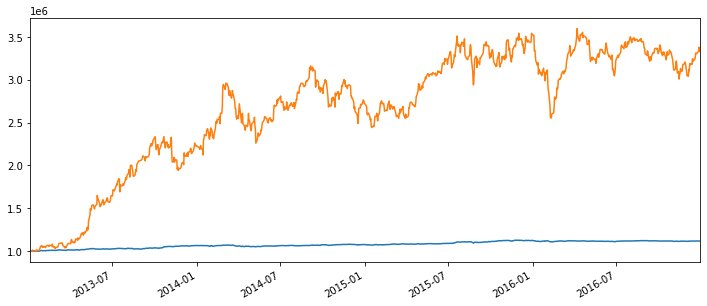

In [15]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))

<AxesSubplot:>

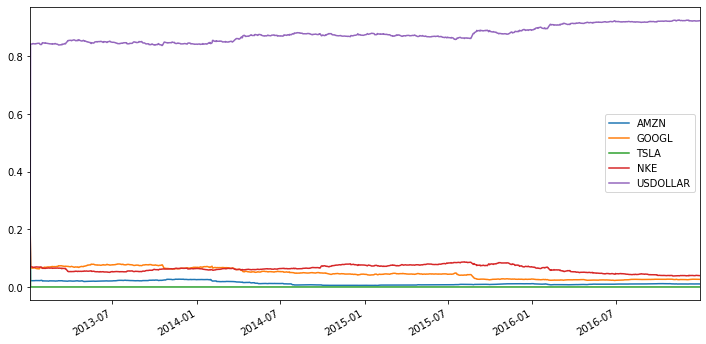

In [16]:
results[0].w.plot(figsize=(12,6))

In [24]:
# Dimensions are [risk_aversion, trade_aversion, holding_cost, bid_ask_spread, borrow_cost]

In [16]:
sampler = qmc.Sobol(d=5, scramble=False)

In [20]:
sample = sampler.random(3000)

In [21]:
sample

array([[0.14978027, 0.49499512, 0.98132324, 0.30310059, 0.51550293],
       [0.64978027, 0.99499512, 0.48132324, 0.80310059, 0.01550293],
       [0.89978027, 0.24499512, 0.73132324, 0.05310059, 0.26550293],
       ...,
       [0.85559082, 0.89660645, 0.95080566, 0.62902832, 0.70910645],
       [0.60559082, 0.14660645, 0.20080566, 0.37902832, 0.95910645],
       [0.10559082, 0.64660645, 0.70080566, 0.87902832, 0.45910645]])

In [55]:
np.mean(sample, axis=0)

array([0.49980359, 0.50002421, 0.49963668, 0.50001103, 0.50038188])

In [41]:
lowers = [0.1, 5.5, 0.1, 1e-04, 1e-04]
uppers = [1000, 8, 100, 1e-02, 1e-03]

In [42]:
scaled_sample = qmc.scale(sample, lowers, uppers)

array([[5.00050000e+02, 6.75000000e+00, 5.00500000e+01, 5.05000000e-03,
        5.50000000e-04],
       [7.50025000e+02, 6.12500000e+00, 2.50750000e+01, 2.57500000e-03,
        7.75000000e-04],
       [2.50075000e+02, 7.37500000e+00, 7.50250000e+01, 7.52500000e-03,
        3.25000000e-04],
       ...,
       [7.12675220e+02, 5.87658691e+00, 5.20743408e+01, 7.38723145e-03,
        8.03344727e-04],
       [2.12725220e+02, 7.12658691e+00, 2.12434082e+00, 2.43723145e-03,
        3.53344727e-04],
       [1.50231470e+02, 6.34533691e+00, 5.83180908e+01, 4.29348145e-03,
        9.72094727e-04]])

In [57]:
extract_results(results[0])

[72.05850593104746,
 71.94323722329396,
 76.5321877167474,
 0.940506512708237,
 70.10326331796388]

In [14]:
import os

In [15]:
os.chdir('../../')

In [16]:
os.getcwd()

'/home/sebtsh/fast-drbo'

In [142]:
scaled_samples = pickle.load(open('data/portfolio/scaled_samples.p','rb'))

In [143]:
all_results = pickle.load(open('data/portfolio/all_results.p','rb'))

In [19]:
import matplotlib.pyplot as plt

(array([ 15.,  68., 111.,  85.,  96.,  84.,  69.,  98.,  80., 128., 133.,
        174., 371.,  71.,  40.,  33.,  24.,  25.,  28.,  16.,  17.,  11.,
         12.,  20.,  11.,  19.,  11.,  15.,  11.,  11.,   8.,   5.,   5.,
          6.,   5.,   8.,   7.,   3.,   8.,   3.,   5.,   5.,   4.,   4.,
          6.,   2.,   5.,   3.,   5.,   3.,   2.,   1.,   1.,   2.,   2.,
          3.,   1.,   5.,   5.,   3.,   1.,   2.,   1.,   0.,   2.,   1.,
          1.,   4.,   2.,   3.,   0.,   0.,   2.,   1.,   2.,   1.,   2.,
          0.,   0.,   2.,   0.,   3.,   2.,   1.,   2.,   1.]),
 array([-1.07969866, -1.00015506, -0.92061146, -0.84106786, -0.76152426,
        -0.68198067, -0.60243707, -0.52289347, -0.44334987, -0.36380627,
        -0.28426268, -0.20471908, -0.12517548, -0.04563188,  0.03391172,
         0.11345531,  0.19299891,  0.27254251,  0.35208611,  0.43162971,
         0.5111733 ,  0.5907169 ,  0.6702605 ,  0.7498041 ,  0.8293477 ,
         0.90889129,  0.98843489,  1.06797849,  1.147

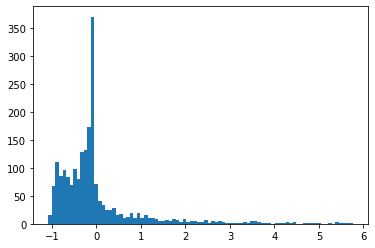

In [149]:
plt.hist((all_results[:, 0] - np.mean(all_results[:, 0])) / np.std(all_results[:, 0]), bins='auto')

In [21]:
all_results[:, 0]

array([171.20933332,   2.79293346,   0.92357702, ...,   1.63869376,
         2.45430878,   3.33066261])

In [22]:
scaled_samples[0]

array([1.0e-01, 5.5e+00, 1.0e-01, 1.0e-04, 1.0e-04])

In [23]:
scaled_samples[1]

array([5.0005e+02, 6.7500e+00, 5.0050e+01, 5.0500e-03, 5.5000e-04])

In [25]:
! pip install scikit-learn

     |████████████████████████████████| 22.3 MB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 60.5 MB/s eta 0:00:01


In [26]:
from sklearn.neighbors import NearestNeighbors

In [27]:
neigh = NearestNeighbors(n_neighbors=5)

In [48]:
neigh.fit(scaled_samples[:, 0:1])

NearestNeighbors()

In [50]:
neigh.kneighbors(scaled_samples[0, 0:1][None, :])

(array([[0.        , 0.48823242, 0.73234863, 0.97646484, 1.46469727]]),
 array([[   0, 2047, 2048, 1023, 1024]]))

In [31]:
scaled_samples[1663]

array([1.03528809e+01, 6.84887695e+00, 3.56333008e+00, 1.46801758e-03,
       5.56591797e-04])

In [34]:
all_results[1663]

array([27.62332236, 27.50805365, 18.69949163,  1.47179059, 17.58753614])

In [35]:
all_results[2304]

array([34.32134688, 34.20607817, 28.86735179,  1.18552932, 27.90240818])

In [36]:
all_results[1535]

array([34.32134758, 34.20607888, 28.86735299,  1.18552929, 27.90240968])

In [37]:
all_results[896]

array([34.32134527, 34.20607656, 28.86734948,  1.18552936, 27.90240453])

In [38]:
scaled_samples[2304]

array([6.69113770e+00, 5.96691895e+00, 8.85588379e+00, 9.56252441e-03,
       6.28442383e-04])

In [40]:
scaled_samples[1535]

array([3.51762695e+00, 7.69604492e+00, 1.02948730e+01, 6.44702148e-03,
       8.45751953e-04])

In [41]:
scaled_samples[896]

array([8.88818359e+00, 6.54248047e+00, 7.41689453e+00, 5.33037109e-03,
       4.01464844e-04])

In [32]:
scaled_samples[0]

array([1.0e-01, 5.5e+00, 1.0e-01, 1.0e-04, 1.0e-04])

In [ ]:
plt.hist(scaled_samples[:, 1], bins='auto')

In [54]:
scaled_samples[2047]

array([5.88232422e-01, 7.06860352e+00, 9.31221191e+01, 3.57563477e-03,
       6.67333984e-04])

In [55]:
all_results[2047]

array([34.32135627, 34.20608757, 28.86736373,  1.18552915, 27.9024204 ])

In [108]:
all_results = pickle.load(open("data/portfolio/all_results.p",'rb'))

In [141]:
np.histogram(all_results[:, 3], bins=20)

(array([  42,   16,   16,   37,   58,   26,   16,   21,   13,   12,    9,
           4,    9,    6,    7,    3,   16,   21,   42, 1674]),
 array([0.84697728, 0.86408173, 0.88118619, 0.89829065, 0.9153951 ,
        0.93249956, 0.94960402, 0.96670848, 0.98381293, 1.00091739,
        1.01802185, 1.0351263 , 1.05223076, 1.06933522, 1.08643967,
        1.10354413, 1.12064859, 1.13775305, 1.1548575 , 1.17196196,
        1.18906642]))

In [110]:
np.argmax(all_results[:, 0])

546

In [111]:
all_results[546]

array([94.5556518 , 94.44038309, 80.42359918,  1.17487103, 64.74917225])

In [113]:
sampler = qmc.Sobol(d=4, scramble=False)
sample = sampler.random(2048)
lowers = [5.5, 0.1, 1e-04, 1e-04]
uppers = [8, 100, 1e-02, 1e-03]
scaled_samples = qmc.scale(sample, lowers, uppers)

In [115]:
scaled_samples[546]

array([7.49951172e+00, 2.67334961e+01, 1.09667969e-04, 2.74902344e-04])

In [121]:
np.argmin(all_results[:, 0])

537

In [122]:
scaled_samples[537]

array([7.14794922e+00, 9.07319336e+01, 9.85498047e-03, 6.82714844e-04])

In [147]:
scaled_samples

array([[1.00000000e-01, 5.50000000e+00, 1.00000000e-04, 1.00000000e-04],
       [5.05000000e+00, 6.75000000e+00, 8.00000000e-04, 5.50000000e-04],
       [7.52500000e+00, 6.12500000e+00, 4.50000000e-04, 3.25000000e-04],
       ...,
       [7.52983398e+00, 7.69360352e+00, 1.05361328e-03, 1.90966797e-04],
       [5.05483398e+00, 5.81860352e+00, 7.03613281e-04, 8.65966797e-04],
       [1.04833984e-01, 7.06860352e+00, 1.40361328e-03, 4.15966797e-04]])

In [152]:
standardized_returns = (all_results[:, 0] - np.mean(all_results[:, 0])) / np.std(all_results[:, 0])

(array([ 15.,  68., 111.,  85.,  96.,  84.,  69.,  98.,  80., 128., 133.,
        174., 371.,  71.,  40.,  33.,  24.,  25.,  28.,  16.,  17.,  11.,
         12.,  20.,  11.,  19.,  11.,  15.,  11.,  11.,   8.,   5.,   5.,
          6.,   5.,   8.,   7.,   3.,   8.,   3.,   5.,   5.,   4.,   4.,
          6.,   2.,   5.,   3.,   5.,   3.,   2.,   1.,   1.,   2.,   2.,
          3.,   1.,   5.,   5.,   3.,   1.,   2.,   1.,   0.,   2.,   1.,
          1.,   4.,   2.,   3.,   0.,   0.,   2.,   1.,   2.,   1.,   2.,
          0.,   0.,   2.,   0.,   3.,   2.,   1.,   2.,   1.]),
 array([-1.07969866, -1.00015506, -0.92061146, -0.84106786, -0.76152426,
        -0.68198067, -0.60243707, -0.52289347, -0.44334987, -0.36380627,
        -0.28426268, -0.20471908, -0.12517548, -0.04563188,  0.03391172,
         0.11345531,  0.19299891,  0.27254251,  0.35208611,  0.43162971,
         0.5111733 ,  0.5907169 ,  0.6702605 ,  0.7498041 ,  0.8293477 ,
         0.90889129,  0.98843489,  1.06797849,  1.147

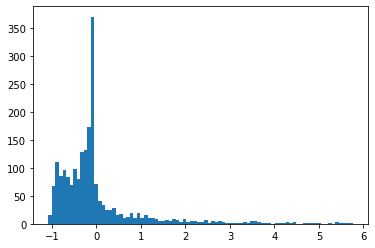

In [153]:
plt.hist(standardized_returns, bins='auto')

In [166]:
standardized_returns.shape

(2048,)

In [155]:
lowers = np.array([0.1, 5.5, 1e-04, 1e-04])
uppers = np.array([10, 8, 1.5e-03, 1e-03])

In [163]:
np.max((scaled_samples - lowers) / (uppers - lowers), axis=0)

array([0.99951172, 0.99951172, 0.99951172, 0.99951172])

In [164]:
normalized_samples = (scaled_samples - lowers) / (uppers - lowers)

In [165]:
normalized_samples.shape

(2048, 4)

In [ ]:
import gpflow as gpf

In [203]:
k = gpf.kernels.SquaredExponential(lengthscales=[0.1, 0.1, 0.1, 0.1])

In [204]:
gp = gpf.models.GPR(data=(normalized_samples, standardized_returns[:, None]),
                    kernel=k)

In [205]:
gp.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [206]:
gp

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(4,)",float64,"[0.1, 0.1, 0.1..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.009999999999999998


In [207]:
opt = gpf.optimizers.Scipy()

In [208]:
opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=100))

In [209]:
opt_logs

      fun: -2889.8795642244722
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.48701844e-04,  5.38556862e-05, -1.63968521e-03, -2.32989475e-05,
        1.83197941e-05,  1.06833600e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 31
     njev: 36
   status: 0
  success: True
        x: array([-2.7399264 ,  3.67701767, -1.80772674, 17.52734164,  0.54296372,
       -6.58083732])

In [210]:
gp.kernel.lengthscales

<Parameter: dtype=float64, shape=[4], fn="softplus", numpy=array([ 0.06257575,  3.70200128,  0.15188519, 17.52734167])>

In [217]:
gp.training_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=-2889.8795642244722>

In [211]:
opt_fmean, opt_fvar = gp.predict_f(normalized_samples)

In [214]:
opt_errors = opt_fmean - standardized_returns[:, None]

In [247]:
np.linalg.norm(opt_errors)

1.49386092715217

In [260]:
k = gpf.kernels.SquaredExponential(lengthscales=[0.1, 1, 0.1, 1])
guess_gp = gpf.models.GPR(data=(normalized_samples, standardized_returns[:, None]),
                    kernel=k)
guess_gp.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [249]:
guess_fmean, guess_fvar = guess_gp.predict_f(normalized_samples)

In [250]:
guess_errors = guess_fmean - standardized_returns[:, None]

In [251]:
np.linalg.norm(guess_errors)

1.5992586194931597

In [259]:
guess_gp.training_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=-1780.8205910222973>

In [253]:
guess_fmean

<tf.Tensor: shape=(2048, 1), dtype=float64, numpy=
array([[ 5.43284527],
       [-0.19057297],
       [-0.81393953],
       ...,
       [-0.22568565],
       [-0.47200773],
       [ 2.27731374]])>

In [254]:
opt_fmean

<tf.Tensor: shape=(2048, 1), dtype=float64, numpy=
array([[ 5.55125964],
       [-0.20855455],
       [-0.82406906],
       ...,
       [-0.21807888],
       [-0.46465165],
       [ 2.39270509]])>

In [255]:
standardized_returns[:, None]

array([[ 5.49239198],
       [-0.17500637],
       [-0.80935964],
       ...,
       [-0.22941851],
       [-0.47077929],
       [ 2.38407101]])

In [261]:
pickle.dump(standardized_returns[:, None], open("standardized_returns.p", "wb"))

In [263]:
pickle.dump(normalized_samples, open("normalized_samples.p", "wb"))

In [264]:
obj_k = gpf.kernels.SquaredExponential(lengthscales=[0.1, 1, 0.1, 1])

In [284]:
jitter = 1e-03

In [285]:
cov = obj_k(normalized_samples) + jitter * np.eye(len(normalized_samples), dtype=np.float32)

In [286]:
L_inv = np.linalg.inv(np.linalg.cholesky(cov))

In [287]:
K_inv_f = L_inv.T @ L_inv @ standardized_returns[:, None]

In [288]:
obj_func = lambda x: obj_k(x, normalized_samples) @ K_inv_f

In [289]:
obj_func(normalized_samples)

<tf.Tensor: shape=(2048, 1), dtype=float64, numpy=
array([[ 5.48603317],
       [-0.18561668],
       [-0.81267079],
       ...,
       [-0.22986219],
       [-0.47548169],
       [ 2.34683704]])>

In [292]:
def get_obj_func_from_samples(kernel, X, y, jitter=1e-03):
    """
    Constructs an objective function from samples. Interpolates between the samples like a GP posterior would.
    :param kernel: a GPflow kernel
    :param X: array of shape (n, d)
    :param y: array of shape (n, 1)
    :param jitter:
    :return:
    """
    cov = kernel(X) + jitter * np.eye(len(X), dtype=np.float32)
    L_inv = np.linalg.inv(np.linalg.cholesky(cov))
    K_inv_f = L_inv.T @ L_inv @ y
    return lambda x: kernel(x, X) @ K_inv_f

In [295]:
obj_func = get_obj_func_from_samples(obj_k, normalized_samples, standardized_returns[:, None])

In [296]:
obj_func(normalized_samples)

<tf.Tensor: shape=(2048, 1), dtype=float64, numpy=
array([[ 5.48603317],
       [-0.18561668],
       [-0.81267079],
       ...,
       [-0.22986219],
       [-0.47548169],
       [ 2.34683704]])>

In [297]:
ls = np.array([0, 1, 2, 3])

In [302]:
from core.utils import construct_grid_1d, cross_product, get_discrete_normal_dist, get_discrete_uniform_dist, \
    get_margin, get_robust_expectation_and_action

In [324]:
action_dims = 2
context_dims = 2
action_lowers = [0] * action_dims
action_uppers = [1] * action_dims
context_lowers = [0] * context_dims
context_uppers = [1] * context_dims
action_density_per_dim = 20
context_density_per_dim = 20

# Action space
action_points = construct_grid_1d(action_lowers[0], action_uppers[0], action_density_per_dim)
for i in range(action_dims - 1):
    action_points = cross_product(action_points,
                                  construct_grid_1d(action_lowers[i + 1], action_uppers[i + 1],
                                                    action_density_per_dim))

# Context space
context_points = construct_grid_1d(context_lowers[0], context_uppers[0], context_density_per_dim)
for i in range(context_dims - 1):
    context_points = cross_product(context_points,
                                   construct_grid_1d(context_lowers[i + 1], context_uppers[i + 1],
                                                     context_density_per_dim))
search_points = cross_product(action_points, context_points)

In [325]:
ref_var = 0.1
ref_means = np.array([[0., 0.], [0.25, 0.25], [0.5, 0.5]])
ref_cov = ref_var * np.eye(context_dims)

In [326]:
divergence = 'MMD_approx'
ls = [0.1, 1, 0.1, 1]
lengthscales = np.array(ls)
context_lengthscales = lengthscales[-context_dims:]
mmd_kernel = gpf.kernels.SquaredExponential(lengthscales=context_lengthscales)

In [338]:
ref_mean = ref_means[1]

ref_dist_func = lambda x: get_discrete_normal_dist(context_points, ref_mean, ref_cov)
true_dist_func = lambda x: get_discrete_uniform_dist(context_points)
margin = get_margin(ref_dist_func(0), true_dist_func(0), mmd_kernel, context_points, divergence)
print("Margin: {}".format(margin))

Margin: [[0.24736733]]


In [339]:
true_dist_func(0)

array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
      

In [333]:
context_points

array([[0.        , 0.        ],
       [0.        , 0.05263158],
       [0.        , 0.10526316],
       [0.        , 0.15789474],
       [0.        , 0.21052632],
       [0.        , 0.26315789],
       [0.        , 0.31578947],
       [0.        , 0.36842105],
       [0.        , 0.42105263],
       [0.        , 0.47368421],
       [0.        , 0.52631579],
       [0.        , 0.57894737],
       [0.        , 0.63157895],
       [0.        , 0.68421053],
       [0.        , 0.73684211],
       [0.        , 0.78947368],
       [0.        , 0.84210526],
       [0.        , 0.89473684],
       [0.        , 0.94736842],
       [0.        , 1.        ],
       [0.05263158, 0.        ],
       [0.05263158, 0.05263158],
       [0.05263158, 0.10526316],
       [0.05263158, 0.15789474],
       [0.05263158, 0.21052632],
       [0.05263158, 0.26315789],
       [0.05263158, 0.31578947],
       [0.05263158, 0.36842105],
       [0.05263158, 0.42105263],
       [0.05263158, 0.47368421],
       [0.

In [341]:
ref_dist_func(0)

array([3.66731663e-03, 4.12550634e-03, 4.51414799e-03, 4.80445365e-03,
       4.97372657e-03, 5.00829020e-03, 4.90531326e-03, 4.67319271e-03,
       4.33042295e-03, 3.90316241e-03, 3.42194175e-03, 2.91808732e-03,
       2.42043618e-03, 1.95280407e-03, 1.53247496e-03, 1.16976275e-03,
       8.68504091e-04, 6.27213837e-04, 4.40584359e-04, 3.01031680e-04,
       4.12550634e-03, 4.64094168e-03, 5.07813970e-03, 5.40471578e-03,
       5.59513742e-03, 5.63401939e-03, 5.51817664e-03, 5.25705526e-03,
       4.87146030e-03, 4.39081839e-03, 3.84947465e-03, 3.28266931e-03,
       2.72284230e-03, 2.19678484e-03, 1.72394037e-03, 1.31591137e-03,
       9.77013849e-04, 7.05577109e-04, 4.95630390e-04, 3.38642182e-04,
       4.51414799e-03, 5.07813970e-03, 5.55652379e-03, 5.91386483e-03,
       6.12222507e-03, 6.16476990e-03, 6.03801423e-03, 5.75229401e-03,
       5.33037424e-03, 4.80445365e-03, 4.21211284e-03, 3.59191184e-03,
       2.97934655e-03, 2.40373207e-03, 1.88634347e-03, 1.43987627e-03,
      

In [19]:
X = pickle.load(open("normalized_samples.p", "rb"))
y = pickle.load(open("standardized_returns.p", "rb"))